<a href="https://colab.research.google.com/github/Grcf2585/RESSBIO/blob/S2-based-water-parameters-retrieval/S2_water_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install the required libraries**

In [ ]:
!pip install geemap
!pip install earthengine-api
!pip install PyShp
!pip install PyCRS
!pip install geopandas
!pip install pygal
!pip install ipygee
#geemap.update_package()

**Import libraries**

In [65]:
import ee
import geemap
import geemap.colormaps as cm

from ipyleaflet import *
from ipywidgets import Label
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import datetime
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.io import loadmat, savemat
from scipy.interpolate import Akima1DInterpolator
from scipy import signal
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import matplotlib.ticker as ticker

import pandas as pd
from datetime import datetime, timedelta
import math
from shapely.geometry import box
import time

import scipy.io
import os
import pickle
import datetime
import numpy as np
import array
import matplotlib.pyplot as plt

import pycrs
import shapely
import shapefile as shp
from shapely.geometry import mapping

import ipygee as ui
import pygal
from ipygee import *
from ipygee import chart

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Authenticate and initialize ee**

In [ ]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

**Select the Area of Interest**

In [11]:
Map = geemap.Map()
Map.default_style = {'cursor': 'crosshair'}
Map.add_basemap('SATELLITE')

# Center the map in the desired country
country = 'Spain'
country_bounds = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filterMetadata('country_na', 'equals', country);
Map.centerObject(country_bounds,8)
Map

Map(center=[40.35722509547827, -3.499564837147696], controls=(WidgetControl(options=['position', 'transparent_…

**Retrieve the ROI from the map**

In [12]:
roi_shp= '/content/drive/MyDrive/Prometeo/ROIs Albufera/N_Polygon.shp'
roi_N = geemap.shp_to_ee(roi_shp)
Map.addLayer(roi_N, {},'Albufera ROI_N')

roi_shp= '/content/drive/MyDrive/Prometeo/ROIs Albufera/S_Polygon.shp'
roi_S = geemap.shp_to_ee(roi_shp)
Map.addLayer(roi_S, {},'Albufera ROI_S')

roi_shp= '/content/drive/MyDrive/Prometeo/ROIs Albufera/NW_Polygon.shp'
roi_NW = geemap.shp_to_ee(roi_shp)
Map.addLayer(roi_NW, {},'Albufera ROI_NW')

roi_shp= '/content/drive/MyDrive/Prometeo/ROIs Albufera/SW_Polygon.shp'
roi_SW = geemap.shp_to_ee(roi_shp)
Map.addLayer(roi_SW, {},'Albufera ROI_SW')

roi_shp= '/content/drive/MyDrive/Prometeo/ROIs Albufera/W_Polygon.shp'
roi_W = geemap.shp_to_ee(roi_shp)
Map.addLayer(roi_W, {},'Albufera ROI_W')

Albufera_shp= '/content/drive/MyDrive/Prometeo/ROIs Albufera/Albufera curvas.shp'
roi_Albufera = geemap.shp_to_ee(Albufera_shp)
Map.addLayer(roi_Albufera, {},'Albufera ROI')


In [ ]:
feature = Map.draw_last_feature
roi_show_map = feature.geometry()

**Model import**

In [13]:
!cp /content/drive/MyDrive/GEE_CHL_GPR_10KCV_model_1.py .
!cp /content/drive/MyDrive/ZSD_Chl_GPR_MLRA_4KCV_model_20230216.py .
!cp /content/drive/MyDrive/ZSD_Chl_GPR_MLRA_70train_model_20230216.py .
!cp /content/drive/MyDrive/PC_GPR_4K_model_gee.py .


import GEE_CHL_GPR_10KCV_model_1
import ZSD_Chl_GPR_MLRA_4KCV_model_20230216
import ZSD_Chl_GPR_MLRA_70train_model_20230216
import PC_GPR_4K_model_gee

In [14]:
#Albufera_insitu_data = loadmat('drive/MyDrive/Prometeo/Embarca_Insitu_Albufera_2016_2023.mat',squeeze_me=True)
Albufera_insitu_data = loadmat('drive/MyDrive/Prometeo/Centro_Insitu_Albufera_2016_2023.mat',squeeze_me=True)
X_insitu = np.array(Albufera_insitu_data['Insitu_date'])
X_insitu = pd.to_datetime(X_insitu-719529, unit='D')
Chl_insitu = Albufera_insitu_data['Chlorophyll']
Secchi_insitu = Albufera_insitu_data['Secchi']

**Functions**

In [15]:
# Auxiliar function for mapping : (1..n) -> (B1..Bn)
def band_names(element):
  bandName = ee.String('B').cat(ee.Number(element).int().format())
  return bandName

def addDoy(image):
  doy = image.date().getRelative('day', 'year')
  doyBand = ee.Image.constant(doy).uint16().rename('doy')
  return image.addBands(doyBand)

In [16]:
# Water variable GPR for mean prediction
def water_var_GPR(image_orig):
  
  # Create List of Bands of Dimension n (Xtrain[n,n])
  XTrain_dim = currentModel['X_train'].length().get([0]).getInfo();

  band_sequence   = (ee.List.sequence(1, XTrain_dim)
                    .map(band_names));
  
  # Create a list of band names for flattening operation 
  im_norm_ell2D_hypell = image_orig.subtract(ee.Image(currentModel['mx'])).divide(ee.Image(currentModel['sx'])).multiply(ee.Image(currentModel['hyp_ell'])).toArray().toArray(1); 
  
  im_norm_ell2D = image_orig.subtract(ee.Image(currentModel['mx'])).divide(ee.Image(currentModel['sx'])).toArray().toArray(1); 
  
  PtTPt  = im_norm_ell2D_hypell.matrixTranspose().matrixMultiply(im_norm_ell2D).arrayProject([0]).multiply(-0.5); 
  
  PtTDX  = ee.Image(currentModel['X_train']).matrixMultiply(im_norm_ell2D_hypell).arrayProject([0]).arrayFlatten([band_sequence]);
  
  arg1   = PtTPt.exp().multiply(currentModel['hyp_sig']);
  
  k_star = PtTDX.subtract(ee.Image(currentModel['XDX_pre_calc']).multiply(0.5)).exp().toArray();
  
  mean_pred = k_star.arrayDotProduct(ee.Image(currentModel['alpha_coefficients']).toArray()).multiply(arg1);
  
  mean_pred = mean_pred.toArray(1).arrayProject([0]).arrayFlatten([[currentModel['veg_index']]]);
  
  mean_pred = mean_pred.add(currentModel['mean_model']);
  
  # Mask values equal or less than 0
  mean_pred = mean_pred.updateMask(mean_pred.gt(0))
  
  image_orig = image_orig.addBands(mean_pred)
  
  return image_orig.select(currentModel['veg_index'])

In [17]:
def mask_gt(image):
  veg_index_mask = image.select(currentModel['veg_index']).gt(0).rename('veg_index_mask')
  return image.addBands(veg_index_mask).select('veg_index_mask')

def addVariables(image):
  date = ee.Date(image.get("system:time_start"))
  years = date.difference(ee.Date('1970-01-01'),'days')
  return image.addBands(ee.Image(years).rename('t').float())

In [18]:
def extract_ts(roi, col, band):
    """ Constructs a dataframe with the time series for the ROI with the image
        collection.

        Parameters
        ----------
        roi : ee.Geometry, Region of interest
        
        col : ee.ImageCollection
        
        band : string, Name of the band to retrieve
        
        Returns
        ------
        A pandas dataframe
        
    """
                
    # Auxiliar function to replace the null values with custom value(-9999)
    # so we do not lose the masked values.
    def set_NAN(key,val):       
        return ee.List([val, -9999]).reduce(ee.Reducer.firstNonNull())

    # Retrieve the mean value of the band in the roi and the date of the image
    def get_ts(image):        
        stat = image.select([band]).reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry= roi,
            scale= 20,
            bestEffort= True        
        )
        stat = stat.map(set_NAN)
        return ee.Feature(roi, stat).set({'millis': image.date().millis()})
    
    # List of features containing the reduced value and the date
    ts = col.map(get_ts)
        
    # Lists of values and dates
    y = ts.aggregate_array(band).getInfo()
    dates_ms = ts.aggregate_array('millis').getInfo() # Date in ms
    x = [datetime.fromtimestamp(d//1000.0) for d in dates_ms] # Formatted date    
    
    # Dictionary that will feed the pandas dataframe
    dict = {'date': x, band: y} 
    # Contruct the df and replace the custom NaN values(-9999) with np.nan
    df = pd.DataFrame(dict).replace(-9999, np.nan)    
    return df

In [19]:
# Masking function for water and cloud
def maskS2cloud_and_water(image):
  not_water = image.select('SCL').neq(6);
  not_cloud_low = image.select('SCL').neq(7);
  not_cloud_medium = image.select('SCL').neq(8);
  not_cloud_high = image.select('SCL').neq(9);
  not_cirrus = image.select('SCL').neq(10);
  
  qa = image.select('QA60');
  cloudBitMask = 1 << 10;
  cirrusBitMask = 1 << 11;
  mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0)).And(not_water).And(not_cloud_low)
          .And(not_cloud_medium).And(not_cloud_high).And(not_cirrus))
  return image.updateMask(mask).divide(10000).copyProperties(qa).set('system:time_start', qa.get('system:time_start'))

In [20]:
#Function to mask clouds using the Sentinel-2 QA band
 
def maskS2clouds(image):
    qa = image.select('QA60');
    #Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

    #Both flags should be set to zero, indicating clear conditions.
    #mask = qa.bitwiseAnd(cloudBitMask).eq(0)and(qa.bitwiseAnd(cirrusBitMask).eq(0));
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0));

    return image.updateMask(mask).divide(10000).copyProperties(image).set("system:time_start", image.get("system:time_start"));

In [21]:
# Function to calculate and add Phycocyanin band
#ficocianina_S2 = #e^2.6151*(R740/R665)+3.6369;
#R740 nm = B6
#R665 nm = B4

def addFICOS2(image):
    fico = (((image.select('B6').divide(image.select('B4')).multiply(2.6151)).add(3.6369))).exp().rename('fico')

    return image.addBands(fico)

In [22]:
# Function to calculate and add Chlorophyll band
#TBDO = R740*(1/R665 - 1/R705)
#clorofila_S2 = 104.1*(TBDO^2) + 221.1*TBDO + 2
#R665 = B4
#R705 = B5
#R740 = B6

def addCHLROS2(image):
    tbdo = (image.select('B6').divide(image.select('B4'))).subtract(image.select('B6').divide(image.select('B5')))
    chlro =  ((tbdo.multiply(tbdo).multiply(104.1).add(tbdo.multiply(221.1))).add(2)).rename('chlro')

    return image.addBands(chlro)

In [43]:
# Function to calculate and add Secchi band
#profundidad_Secchi_S2 =  0.224*(R560/R704)+0.0836
#R560 nm = B3
#R704 nm = B5

def addSECCHIS2(image):
    Secchi = ((image.select('B3').divide(image.select('B5')).multiply(0.224)).add(0.0836)).rename('Secchi')
    return image.addBands(Secchi)

Dates of interest and acquisitions configuration parameters

In [28]:
# Configuration Parameters
start_date = '2017-03-28'
end_date = '2023-05-04'
S2_CPP = 3 # CLOUDY_PIXEL_PERCENTAGE
#roi = roi_show_map
roi = roi_N.geometry() # Select the current region of interest, the options are: roi_N, roi_S, roi_W, roi_SW, and roi_NW. 
geometry = roi_Albufera # The Albufera mask is copied as geometry to filter the image collection posteriorly. 

Create the initial image collection with the spectral bands

In [25]:
def clipcol(image):
    clipimage = image.clip(roi_Albufera)
    return clipimage

In [26]:
# Add NDWI band to image collection
def addNDWI(image):
    return image.addBands(image.normalizedDifference(['B3', 'B5']).rename('NDWI'));

# Function to mask out NDWI
def S2maskedWater(image):
    NDWI = image.select(['NDWI']);
    return image.addBands(ee.Image(1).updateMask(NDWI.gte(-0.3)).rename('NDWI_mask')); #lte

# Function to mask out NDWI values greater than 3000
def S2maskedNDWI(image):
    NDWI = image.select(['NDWI']);
    return image.addBands(ee.Image(1).updateMask(NDWI.gte(-0.3)).rename('NDWI_mask')); #lte

def maskBands(image):
  return image.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8A','NDWI']).updateMask(image.select('NDWI_mask'));

In [92]:
# Retrieving Sentinel 2 imagery 
print('SENTINEL-2 time series being retrieved')
S2collection_raw = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                   .filterBounds(roi)\
                   .filterDate(start_date,end_date)\
                   .map(maskS2clouds)\
                   .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than', S2_CPP)\
                   .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8A'])\
          
# Apply water masking functions to the image collection
S2collection_aux = S2collection_raw.map(addNDWI).map(S2maskedWater).map(maskBands);  
S2collection_ini = S2collection_aux.map(clipcol).select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8A']);
# S2collection_ini

SENTINEL-2 time series being retrieved


S2 dates extraction

In [31]:
# Creating labels - Multitemporal plotting 
labels_S2 = S2collection_ini.aggregate_array("system:index").getInfo()

# Dates S2
Dates_S2 = []
for i in labels_S2:
    Dates_S2.append(datetime.datetime.strptime(i.split('_')[0].split('T')[0], '%Y%m%d').date())
Dates_S2.sort()

#datetime.datetime.strptime(date, "%Y-%m-%d")
#https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime

Creating the retrieved image collection by applying Gaussian Process Regression

In [37]:
#GPR retrieval model configuration (Chlorophyll)

currentwatervariable ='Chl'
currentModel = GEE_CHL_GPR_10KCV_model_1.models[currentwatervariable]
S2_GPR_CHL_collection =  S2collection_ini.map(water_var_GPR).select(currentModel['veg_index'])
del currentwatervariable
del currentModel 

#GPR retrieval model configuration (Phycocyanin)
currentwatervariable ='PC'
currentModel = PC_GPR_4K_model_gee.models[currentwatervariable]
S2_GPR_PC_collection =  S2collection_ini.map(water_var_GPR).select(currentModel['veg_index'])
del currentwatervariable
del currentModel 

#GPR retrieval model configuration (Secchi Disc Depth)
currentwatervariable ='ZSD'
currentModel = ZSD_Chl_GPR_MLRA_4KCV_model_20230216.models[currentwatervariable]
S2_GPR_SDD_collection =  S2collection_ini.map(water_var_GPR).select(currentModel['veg_index'])
del currentwatervariable
del currentModel 

Creating the retrieved image collection by applying parametric indices

In [45]:
# Add the Chlorophyll band to the image collection
S2_PI_CHL_collection = S2collection_ini.map(addCHLROS2).select('chlro')

# Add Phycocyanin band to the image collection
S2_PI_PC_collection = S2collection_ini.map(addFICOS2).select('fico')

# Add Secchi Disc Band band to the image collection
S2_PI_SDD_collection = S2collection_ini.map(addSECCHIS2).select('Secchi')

S2 image collection to a numpy array conversion

In [ ]:
# GPR image collections conversion

S2_GPR_CHL_image = S2_GPR_CHL_collection.toBands().unmask(0);
S2_GPR_CHL_image_nparray = geemap.ee_to_numpy(ee_object = S2_GPR_CHL_image.toArray(), region=roi, default_value=None)

S2_GPR_PC_image = S2_GPR_PC_collection.toBands().unmask(0);
S2_GPR_PC_image_nparray = geemap.ee_to_numpy(ee_object = S2_GPR_PC_image.toArray(), region=roi, default_value=None)

S2_GPR_SDD_image = S2_GPR_SDD_collection.toBands().unmask(0);
S2_GPR_SDD_image_nparray = geemap.ee_to_numpy(ee_object = S2_GPR_SDD_image.toArray(), region=roi, default_value=None)

# PI image collections conversion

S2_PI_CHL_image = S2_PI_CHL_collection.toBands().unmask(0);
S2_PI_CHL_image_nparray = geemap.ee_to_numpy(ee_object = S2_PI_CHL_image.toArray(), region=roi, default_value=None)

S2_PI_PC_image = S2_PI_PC_collection.toBands().unmask(0);
S2_PI_PC_image_nparray = geemap.ee_to_numpy(ee_object = S2_PI_PC_image.toArray(), region=roi, default_value=None)

S2_PI_SDD_image = S2_PI_SDD_collection.toBands().unmask(0);
S2_PI_SDD_image_nparray = geemap.ee_to_numpy(ee_object = S2_PI_SDD_image.toArray(), region=roi, default_value=None)

print('S2 ROI Dimension')
print(S2_GPR_CHL_image_nparray.shape)

In [48]:
# GPR numpy array images parcel mean calculations

S2_GPR_CHL_parcel_mean = np.mean(S2_GPR_CHL_image_nparray, axis = 0)
S2_GPR_CHL_parcel_mean = np.mean(S2_GPR_CHL_parcel_mean, axis = 0)
S2_GPR_CHL_parcel_std = np.std(S2_GPR_CHL_parcel_mean, axis=0)

S2_GPR_PC_parcel_mean = np.mean(S2_GPR_PC_image_nparray, axis = 0)
S2_GPR_PC_parcel_mean = np.mean(S2_GPR_PC_parcel_mean, axis = 0)
S2_GPR_PC_parcel_std = np.std(S2_GPR_PC_parcel_mean, axis=0)

S2_GPR_SDD_parcel_mean = np.mean(S2_GPR_SDD_image_nparray, axis = 0)
S2_GPR_SDD_parcel_mean = np.mean(S2_GPR_SDD_parcel_mean, axis = 0)
S2_GPR_SDD_parcel_std = np.std(S2_GPR_SDD_parcel_mean, axis=0)

# PI numpy array images parcel mean calculations

S2_PI_CHL_parcel_mean = np.mean(S2_PI_CHL_image_nparray, axis = 0)
S2_PI_CHL_parcel_mean = np.mean(S2_PI_CHL_parcel_mean, axis = 0)
S2_PI_CHL_parcel_std = np.std(S2_PI_CHL_parcel_mean, axis=0)

S2_PI_PC_parcel_mean = np.mean(S2_PI_PC_image_nparray, axis = 0)
S2_PI_PC_parcel_mean = np.mean(S2_PI_PC_parcel_mean, axis = 0)
S2_PI_PC_parcel_std = np.std(S2_PI_PC_parcel_mean, axis=0)

S2_PI_SDD_parcel_mean = np.mean(S2_PI_SDD_image_nparray, axis = 0)
S2_PI_SDD_parcel_mean = np.mean(S2_PI_SDD_parcel_mean, axis = 0)
S2_PI_SDD_parcel_std = np.std(S2_PI_SDD_parcel_mean, axis=0)

S2 time-series plotting

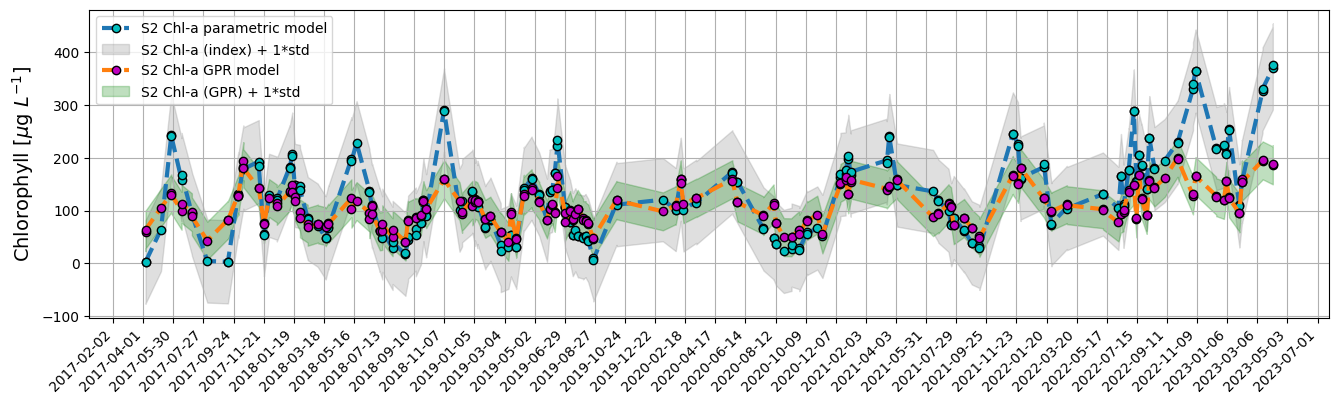

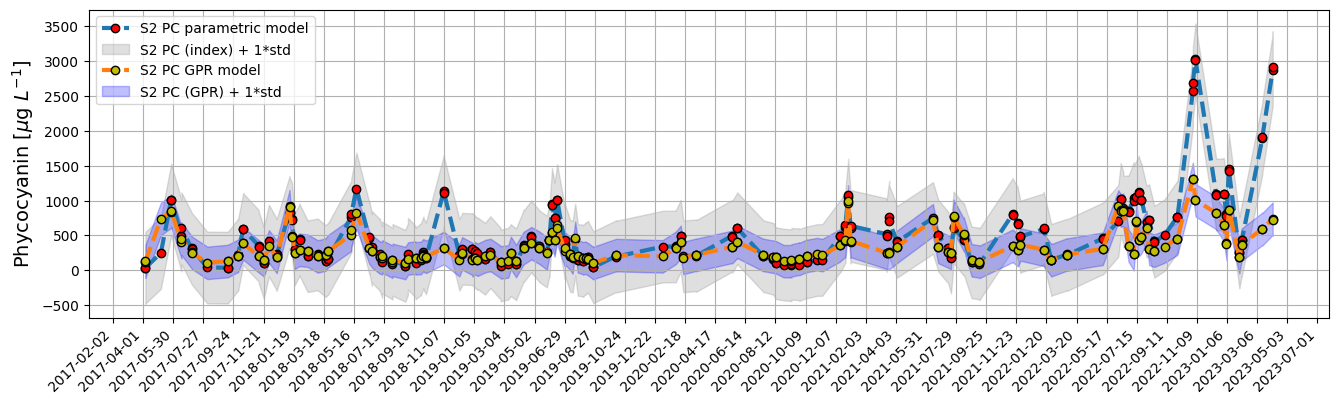

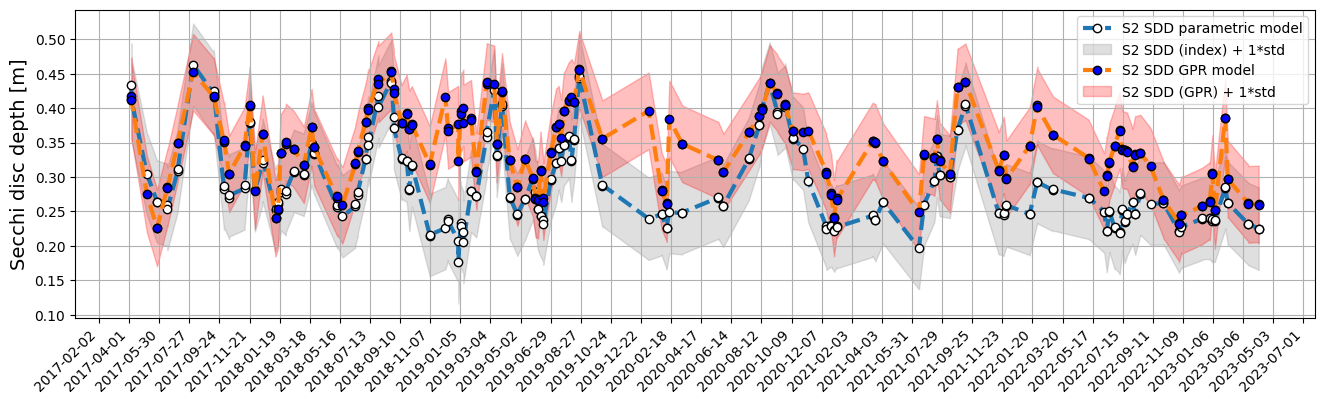

In [55]:
#Comparative Graphs

axmaxloc = S2_PI_CHL_image_nparray.shape[2]/4;
axminloc = S2_PI_CHL_image_nparray.shape[2]/4;

# Sentinel 2 Chlorophyll parametric index model vs GPR model time series plotting 

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(Dates_S2,S2_PI_CHL_parcel_mean,linestyle="--",marker="o",markerfacecolor='c',markeredgecolor='k',markersize=6,lw=3,label='S2 Chl-a parametric model')
plt.fill_between(Dates_S2, S2_PI_CHL_parcel_mean-S2_PI_CHL_parcel_std,S2_PI_CHL_parcel_mean+S2_PI_CHL_parcel_std ,alpha=0.25,color='grey',label='S2 Chl-a (index) + 1*std')
plt.plot(Dates_S2,S2_GPR_CHL_parcel_mean,linestyle="--",marker="o",markerfacecolor='m',markeredgecolor='k',markersize=6,lw=3,label='S2 Chl-a GPR model')
plt.fill_between(Dates_S2, S2_GPR_CHL_parcel_mean-S2_GPR_CHL_parcel_std,S2_GPR_CHL_parcel_mean+S2_GPR_CHL_parcel_std ,alpha=0.25,color='green',label='S2 Chl-a (GPR) + 1*std')
#plt.title('S2 Chlorophyll ROI comparison')
plt.legend()
plt.grid(1)
plt.ylabel('Chlorophyll [$\mu$g $L^{-1}$]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

# Sentinel 2 Phycocyanin parametric index model vs GPR model time series plotting 

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(Dates_S2,S2_PI_PC_parcel_mean,linestyle="--",marker="o",markerfacecolor='r',markeredgecolor='k',markersize=6,lw=3,label='S2 PC parametric model')
plt.fill_between(Dates_S2, S2_PI_PC_parcel_mean-S2_PI_PC_parcel_std,S2_PI_PC_parcel_mean+S2_PI_PC_parcel_std ,alpha=0.25,color='grey',label='S2 PC (index) + 1*std')
plt.plot(Dates_S2,S2_GPR_PC_parcel_mean,linestyle="--",marker="o",markerfacecolor='y',markeredgecolor='k',markersize=6,lw=3,label='S2 PC GPR model')
plt.fill_between(Dates_S2, S2_GPR_PC_parcel_mean-S2_GPR_PC_parcel_std,S2_GPR_PC_parcel_mean+S2_GPR_PC_parcel_std ,alpha=0.25,color='blue',label='S2 PC (GPR) + 1*std')
#plt.title('S2 Phycocyanin ROI comparison')
plt.legend()
plt.grid(1)
plt.ylabel('Phycocyanin [$\mu$g $L^{-1}$]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

# Sentinel 2 Secchi Disk Depth parametric index model vs GPR model time series plotting 

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(Dates_S2,S2_PI_SDD_parcel_mean,linestyle="--",marker="o",markerfacecolor='white',markeredgecolor='k',markersize=6,lw=3,label='S2 SDD parametric model')
plt.fill_between(Dates_S2, S2_PI_SDD_parcel_mean-S2_PI_SDD_parcel_std,S2_PI_SDD_parcel_mean+S2_PI_SDD_parcel_std ,alpha=0.25,color='grey',label='S2 SDD (index) + 1*std')
plt.plot(Dates_S2,S2_GPR_SDD_parcel_mean,linestyle="--",marker="o",markerfacecolor='blue',markeredgecolor='k',markersize=6,lw=3,label='S2 SDD GPR model')
plt.fill_between(Dates_S2, S2_GPR_SDD_parcel_mean-S2_GPR_SDD_parcel_std,S2_GPR_SDD_parcel_mean+S2_GPR_SDD_parcel_std ,alpha=0.25,color='red',label='S2 SDD (GPR) + 1*std')
#plt.title('S2 Secchi disc depth ROI comparison')
plt.legend()
plt.grid(1)
plt.ylabel('Secchi disc depth [m]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

**Water parameter mapping**

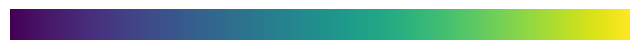

In [57]:
palette_PC = cm.get_palette('viridis', n_class=10)
vis_PC = {'min': 0, 'max': 1200, 'palette': palette_PC}
cm.plot_colormap('viridis', width=8.0, height=0.4, orientation='horizontal')

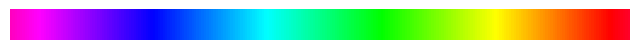

In [58]:
palette_CHL = cm.get_palette('gist_rainbow_r', n_class=10)
vis_CHL = {'min': 0, 'max': 300, 'palette': palette_CHL}
cm.plot_colormap('gist_rainbow_r', width=8.0, height=0.4, orientation='horizontal')

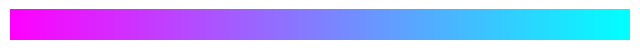

In [59]:
palette_SDD = cm.get_palette('cool_r', n_class=10)
vis_SDD = {'min': 0.25, 'max': 0.45, 'palette': palette_SDD}
cm.plot_colormap('cool_r', width=8.0, height=0.4, orientation='horizontal')

In [66]:
# Map display parameters definition (RGB S2 image)
vizParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.2,
}

In [87]:
u_lat = 39.34
u_lon = -0.35

Map_S2 = geemap.Map()
Map_S2 = geemap.Map(center=(u_lat,u_lon), zoom=13)
Map_S2.set_plot_options(add_marker_cluster=True)
Map_S2

Map(center=[39.34, -0.35], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [84]:
S2collection_list = S2collection_raw.toList(S2collection_raw.size());
S2image = ee.Image(S2collection_list.get(231));

In [117]:
#Map_S2.addLayer(S2image, vizParams,'false color composite')

#Map_S2.addLayer(S2_GPR_CHL_image.select(212),vis_CHL, 'S2 CHL')
#Map_S2.addLayer(S2_GPR_PC_image.select(231),vis_PC, 'S2 PC')
Map_S2.addLayer(S2_PI_PC_image.select(2),vis_PC, 'S2 PC')
#Map_S2.addLayer(S2_PI_CHL_image.select(226),vis_CHL, 'S2 CHL')
#Map_S2.addLayer(S2_PI_CHL_collection.mean(),vis_CHL, 'S2 CHL')
#Map_S2.addLayer(S2_GPR_CHL_collection.mean(),vis_CHL, 'S2 CHL')
#Map_S2.addLayer(S2_GPR_PC_collection.mean(),vis_PC, 'S2 PC')
#Map_S2.addLayer(S2_GPR_SDD_collection.mean(),vis_SDD, 'S2 SDD')
#Map_S2.add_time_slider(S2_GPR_SDD_collection ,vis_SDD, region=roi_Albufera,layer_name='S2 Time-series',labels=labels_S2, time_interval=1)
#Map_S2.add_time_slider(S2_GPR_PC_collection ,vis_PC, region=roi_Albufera,layer_name='S2 Time-series',labels=labels_S2, time_interval=1)
#Map_S2.add_time_slider(S2_GPR_CHL_collection ,vis_CHL, region=roi_Albufera,layer_name='S2 Time-series',labels=labels_S2, time_interval=1)
#Map_S2.addLayer(roi, {},'ROI')
Map_S2.addLayer(roi_Albufera, {},'Albufera ROI',opacity = 0.3)
#Map_S2.add_colorbar(vis_SDD, label="SDD (m)", orientation="vertical", layer_name="SDD GPR")
Map_S2.add_colorbar(vis_PC, label="PC (ug/L)", orientation="horizontal", layer_name="SDD GPR")
#Map_S2.add_colorbar(vis_CHL, label="CHL (ug/L)", orientation="horizontal", layer_name="SDD GPR")

In [ ]:
cm.list_colormaps()

In [90]:
# Chart *series*
test_site = roi_Albufera
chart_ts_GPR_Chl = ui.chart.Image.series(**{
    'imageCollection': S2_GPR_CHL_collection, 
    'region': test_site,
    'scale': 20,
    'reducer': ee.Reducer.mean(),
    'xProperty': 'system:time_start', 
    'system':'index',
    'bands': ['Chl'],
    'labels': ['Date','Chl-a']
})

chart_ts_GPR_Chl.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [89]:
chart_ts_PI_Chl = ui.chart.Image.series(**{
    'imageCollection': S2_PI_CHL_collection, 
    'region': test_site,
    'scale': 20,
    'reducer': ee.Reducer.mean(),
    'xProperty': 'system:time_start',
    'bands': ['chlro'],
    'labels': ['Date','Chl-a']
})

chart_ts_PI_Chl.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [91]:
# Chart *series*
chart_ts_GPR_PC = ui.chart.Image.series(**{
    'imageCollection': S2_GPR_PC_collection, 
    'region': test_site,
    'scale': 20,
    'reducer': ee.Reducer.mean(),
    'xProperty': 'system:time_start', 
    'system':'index',
    'bands': ['PC'],
    'labels': ['Date','PC']
})

chart_ts_GPR_PC.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [95]:
chart_ts_PI_PC = ui.chart.Image.series(**{
    'imageCollection': S2_PI_PC_collection, 
    'region': test_site,
    'scale': 20,
    'reducer': ee.Reducer.mean(),
    'bands': ['fico'],
    'labels': ['Date','PC']
})

chart_ts_PI_PC.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [96]:
# Chart *series*
chart_ts_GPR_SDD = ui.chart.Image.series(**{
    'imageCollection': S2_GPR_SDD_collection, 
    'region': test_site,
    'scale': 300,
    'reducer': ee.Reducer.mean(),
    'xProperty': 'system:time_start',
    'bands': ['ZSD'],
    'labels': ['Date','SDD']
})

chart_ts_GPR_SDD.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [97]:
# Chart *series*
chart_ts_PI_SDD = ui.chart.Image.series(**{
    'imageCollection': S2_PI_SDD_collection, 
    'region': test_site,
    'scale': 300,
    'reducer': ee.Reducer.mean(),
    'xProperty': 'system:time_start',
    'bands': ['Secchi'],
    'labels': ['Date','SDD']
})

chart_ts_PI_SDD.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

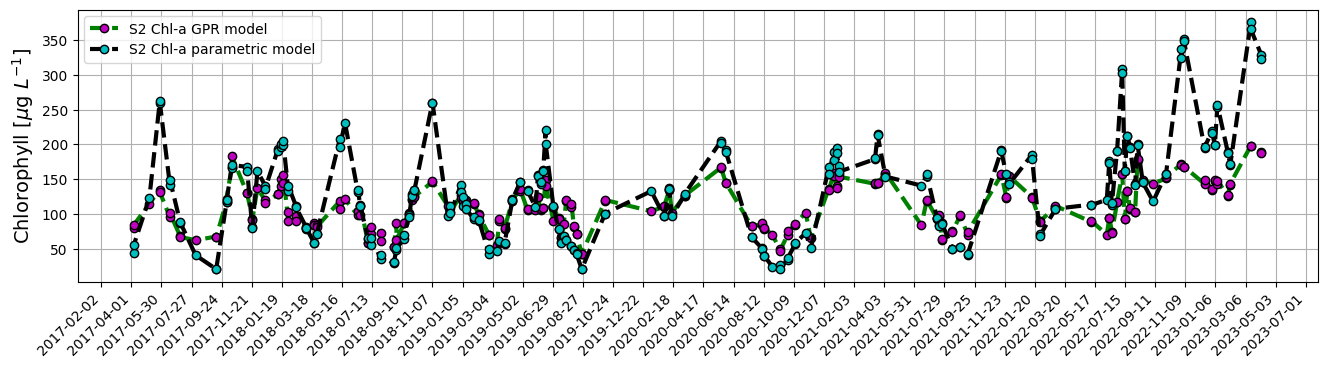

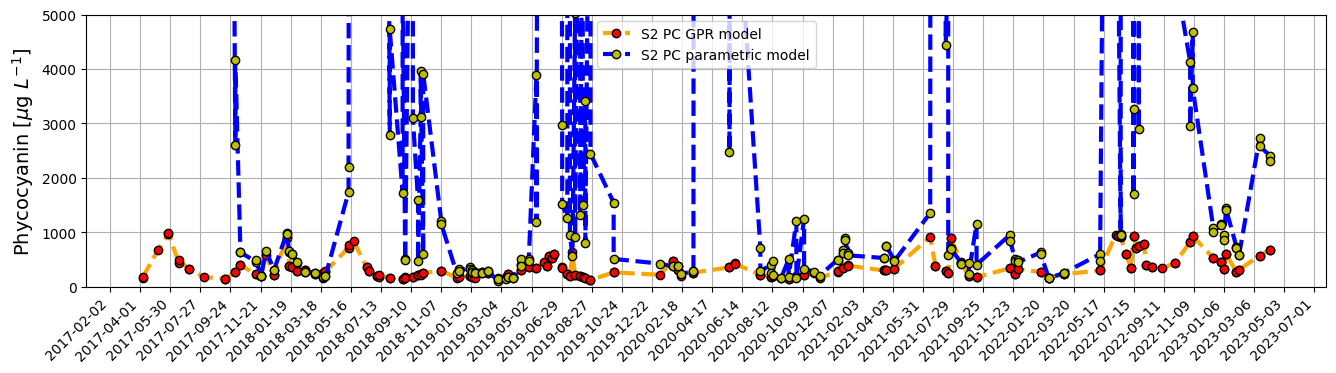

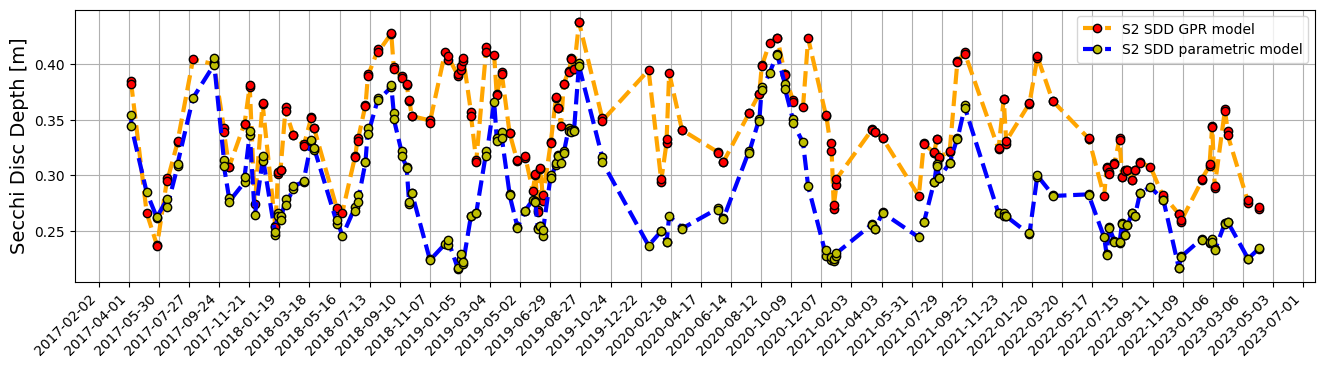

In [100]:
# Water ecological variables time series plotting - Albufera mask

df_GPR_chl = chart_ts_GPR_Chl.dataframe
df_index_chl = chart_ts_PI_Chl.dataframe

df_GPR_PC = chart_ts_GPR_PC.dataframe
df_index_PC = chart_ts_PI_PC.dataframe

df_GPR_SDD = chart_ts_GPR_SDD.dataframe
df_PI_SDD = chart_ts_PI_SDD.dataframe

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
df_GPR_chl.plot(y='Chl', kind='line',figsize=(16,4),color='green', ax=ax,linestyle="--",marker="o",markerfacecolor='m',markeredgecolor='k',markersize=6,lw=3,label='S2 Chl-a GPR model');
df_index_chl.plot(y='chlro', kind='line',figsize=(16,4),lw=3,color='black', ax=ax,linestyle="--",marker="o",markerfacecolor='c',markeredgecolor='k',markersize=6,label='S2 Chl-a parametric model');
plt.legend()
#plt.ylim(0,300)
plt.ylabel('Chlorophyll [$\mu$g $L^{-1}$]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
df_GPR_PC.plot(y='PC', kind='line',figsize=(16,4),color='orange', ax=ax,linestyle="--",marker="o",markerfacecolor='r',markeredgecolor='k',markersize=6,lw=3,label='S2 PC GPR model');
df_index_PC.plot(y='fico', kind='line',figsize=(16,4),lw=3,color='blue', ax=ax,linestyle="--",marker="o",markerfacecolor='y',markeredgecolor='k',markersize=6,label='S2 PC parametric model');
plt.legend()
plt.ylim(0,5000)
plt.ylabel('Phycocyanin [$\mu$g $L^{-1}$]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
df_GPR_SDD.plot(y='ZSD', kind='line',figsize=(16,4),color='orange', ax=ax,linestyle="--",marker="o",markerfacecolor='r',markeredgecolor='k',markersize=6,lw=3,label='S2 SDD GPR model');
df_PI_SDD.plot(y='Secchi', kind='line',figsize=(16,4),lw=3,color='blue', ax=ax,linestyle="--",marker="o",markerfacecolor='y',markeredgecolor='k',markersize=6,label='S2 SDD parametric model');
plt.legend()
plt.ylabel('Secchi Disc Depth [m]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

In [109]:
# Add NDWI_mask band to image collection
NDWI_collection = S2collection_aux.select('NDWI').map(clipcol)
S2_NDWI_mask_image = NDWI_collection.toBands().unmask(0);

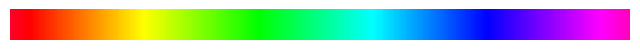

In [113]:
palette_NDWI = cm.get_palette('gist_rainbow', n_class=10)
vis_NDWI = {'min': -1, 'max': 0, 'palette': palette_NDWI}
cm.plot_colormap('gist_rainbow', width=8.0, height=0.4, orientation='horizontal')

In [114]:
u_lat = 39.34
u_lon = -0.35

Map_S2_2 = geemap.Map()
Map_S2_2 = geemap.Map(center=(u_lat,u_lon), zoom=13)
Map_S2_2.set_plot_options(add_marker_cluster=True)
Map_S2_2

Map(center=[39.34, -0.35], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [116]:
#Map_S2_2.add_time_slider(NDWI_collection ,vis_NDWI, region=roi_Albufera,layer_name='S2 Time-series',labels=labels_S2, time_interval=1)
Map_S2_2.addLayer(S2_NDWI_mask_image.select(231),vis_NDWI,'S2 CHL')
#Map_S2_2.addLayer(S2_masked_collection_image.select(212),vis_NDWI,'S2 NDWI')
Map_S2_2.addLayer(roi_Albufera, {},'Albufera ROI',opacity = 0.3)
Map_S2_2.add_colorbar(vis_NDWI, label="NDWI", orientation="horizontal", layer_name="NDWI")

#Map_S2_2.addLayer(S2_CHLRO_image.select(157),vis_CHL, 'S2 CHL')
#Map_S2.add_colorbar(vis_CHL, label="CHL (ug/L)", orientation="vertical", layer_name="SDD CHL")

S1 collection filtering